# 🎬 영화 추천 시스템 - 완전판

## 프로젝트 구조

```
[Part 1] 데이터 준비
    ↓
[Part 2] 하이퍼파라미터 튜닝
         - ε-Greedy: epsilon 튜닝
         - DQN: hidden_dim, lstm_hidden, lr Grid Search
    ↓
[Part 3] 최적 하이퍼파라미터로 최종 모델 학습
    ↓
[Part 4] 4개 알고리즘 비교 평가
    ↓
[Part 5] 최적 알고리즘 선택
    ↓
[Part 6] 유저별 영화 추천 + TMDB API 정보 제공
```

---

## 0. 환경 설정

In [1]:
# GPU 확인
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
import os
import requests
import zipfile
import io
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from collections import defaultdict, deque
import random
from typing import List, Dict, Tuple
from itertools import product
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')

from IPython.display import display, HTML

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

Device: cpu


In [3]:
# TMDB API 키 입력
# 발급: https://www.themoviedb.org/settings/api

TMDB_API_KEY = "YOUR_API_KEY_HERE"  # <-- 여기에 입력!

if TMDB_API_KEY == "YOUR_API_KEY_HERE":
    print("TMDB API 키를 입력해주세요!")
    print("   발급: https://www.themoviedb.org/settings/api")
else:
    print("✅ API 키 설정 완료!")

✅ API 키 설정 완료!


---
# Part 1: 데이터 준비
---

In [4]:
class MovieLensDataLoader:
    def __init__(self, save_dir='./data', min_user_ratings=20, min_movie_ratings=5):
        self.save_dir = save_dir
        self.ratings_path = os.path.join(save_dir, 'ml-latest-small', 'ratings.csv')
        self.movies_path = os.path.join(save_dir, 'ml-latest-small', 'movies.csv')
        self.min_user_ratings = min_user_ratings
        self.min_movie_ratings = min_movie_ratings
        self.data = None
        self.movies_df = None
        self.genre_list = None

    def download_data(self):
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        if os.path.exists(self.ratings_path):
            print("[INFO] 데이터가 이미 존재합니다.")
            return
        url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
        print(f"[INFO] 다운로드 중...")
        r = requests.get(url)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(self.save_dir)
        print("[INFO] 완료.")

    def load_and_preprocess(self):
        ratings = pd.read_csv(self.ratings_path)
        movies = pd.read_csv(self.movies_path)
        self.movies_df = movies.copy()

        all_genres = set()
        for genres in movies['genres']:
            for g in genres.split('|'):
                if g != '(no genres listed)':
                    all_genres.add(g)
        self.genre_list = sorted(list(all_genres))

        df = pd.merge(ratings, movies, on='movieId', how='left')

        movie_counts = df.groupby('movieId')['rating'].count()
        valid_movies = movie_counts[movie_counts >= self.min_movie_ratings].index
        df = df[df['movieId'].isin(valid_movies)]

        user_counts = df.groupby('userId')['rating'].count()
        valid_users = user_counts[user_counts >= self.min_user_ratings].index
        df = df[df['userId'].isin(valid_users)]

        print(f"[INFO] 데이터: {len(df)} rows, 유저 {df['userId'].nunique()}명, 영화 {df['movieId'].nunique()}개")

        df['liked'] = (df['rating'] >= 4.0).astype(int)

        for genre in self.genre_list:
            df[f'genre_{genre}'] = df['genres'].apply(lambda x: 1 if genre in x else 0)

        self.data = df.sort_values(['userId', 'timestamp']).reset_index(drop=True)
        return self.data

    def get_movie_info(self, movie_id):
        movie = self.movies_df[self.movies_df['movieId'] == movie_id]
        if len(movie) == 0:
            return None
        return {
            'movieId': movie_id,
            'title': movie['title'].iloc[0],
            'genres': movie['genres'].iloc[0]
        }

In [5]:
loader = MovieLensDataLoader(min_user_ratings=20, min_movie_ratings=10)
loader.download_data()
data = loader.load_and_preprocess()
print(f"장르 수: {len(loader.genre_list)}")
data.head()

[INFO] 다운로드 중...
[INFO] 완료.
[INFO] 데이터: 80828 rows, 유저 592명, 영화 2269개
장르 수: 19


,userId,movieId,rating,timestamp,title,genres,liked,genre_Action,genre_Adventure,genre_Animation,...,genre_Film-Noir,genre_Horror,genre_IMAX,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,1210,5.0,964980499,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0
1,1,2018,5.0,964980523,Bambi (1942),Animation|Children|Drama,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,2628,4.0,964980523,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0
3,1,2826,4.0,964980523,"13th Warrior, The (1999)",Action|Adventure|Fantasy,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,3578,5.0,964980668,Gladiator (2000),Action|Adventure|Drama,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
def temporal_train_test_split(data, test_ratio=0.2):
    train_list, test_list = [], []
    for user_id, user_df in data.groupby('userId'):
        user_df = user_df.sort_values('timestamp')
        n = len(user_df)
        split_idx = max(1, int(n * (1 - test_ratio)))
        train_list.append(user_df.iloc[:split_idx])
        test_list.append(user_df.iloc[split_idx:])

    train_data = pd.concat(train_list).reset_index(drop=True)
    test_data = pd.concat(test_list).reset_index(drop=True)
    print(f"[INFO] Train: {len(train_data)}, Test: {len(test_data)}")
    return train_data, test_data

train_data, test_data = temporal_train_test_split(data, test_ratio=0.2)

[INFO] Train: 64436, Test: 16392


In [7]:
class RecommenderEvaluator:
    def __init__(self, test_data):
        self.test_data = test_data
        self.user_ground_truth = {}
        for user_id, group in test_data[test_data['liked'] == 1].groupby('userId'):
            self.user_ground_truth[user_id] = set(group['movieId'].tolist())

    def ndcg_at_k(self, user_id, recs, k):
        if user_id not in self.user_ground_truth:
            return 0.0
        actual = self.user_ground_truth[user_id]
        dcg = sum(1.0 / np.log2(i + 2) for i, m in enumerate(recs[:k]) if m in actual)
        idcg = sum(1.0 / np.log2(i + 2) for i in range(min(len(actual), k)))
        return dcg / idcg if idcg > 0 else 0.0

    def hit_rate_at_k(self, user_id, recs, k):
        if user_id not in self.user_ground_truth:
            return 0.0
        actual = self.user_ground_truth[user_id]
        return 1.0 if len(set(recs[:k]) & actual) > 0 else 0.0

    def precision_at_k(self, user_id, recs, k):
        if user_id not in self.user_ground_truth:
            return 0.0
        actual = self.user_ground_truth[user_id]
        return sum(1 for m in recs[:k] if m in actual) / k

    def recall_at_k(self, user_id, recs, k):
        if user_id not in self.user_ground_truth:
            return 0.0
        actual = self.user_ground_truth[user_id]
        if len(actual) == 0:
            return 0.0
        return len(set(recs[:k]) & actual) / len(actual)

    def evaluate_all(self, recommender, user_ids, k=10):
        metrics = {'hit': [], 'prec': [], 'recall': [], 'ndcg': []}
        for user_id in user_ids:
            if user_id not in self.user_ground_truth:
                continue
            recs = recommender.get_recommendations(user_id, k)
            if not recs:
                continue
            rec_ids = [r['movieId'] for r in recs]
            metrics['hit'].append(self.hit_rate_at_k(user_id, rec_ids, k))
            metrics['prec'].append(self.precision_at_k(user_id, rec_ids, k))
            metrics['recall'].append(self.recall_at_k(user_id, rec_ids, k))
            metrics['ndcg'].append(self.ndcg_at_k(user_id, rec_ids, k))

        return {
            'HitRate@K': np.mean(metrics['hit']) if metrics['hit'] else 0,
            'Precision@K': np.mean(metrics['prec']) if metrics['prec'] else 0,
            'Recall@K': np.mean(metrics['recall']) if metrics['recall'] else 0,
            'NDCG@K': np.mean(metrics['ndcg']) if metrics['ndcg'] else 0,
            'n_users': len(metrics['hit'])
        }

evaluator = RecommenderEvaluator(test_data)
print(f"평가 가능 유저: {len(evaluator.user_ground_truth)}명")

평가 가능 유저: 577명


In [8]:
class MovieEmbedding:
    def __init__(self, n_components=20):
        self.n_components = n_components
        self.svd = TruncatedSVD(n_components=n_components, random_state=42)
        self.movie_vectors = None
        self.movie_id_map = None
        self.user_vectors = None
        self.user_id_map = None

    def fit(self, train_data):
        matrix = train_data.pivot_table(
            index='userId', columns='movieId', values='liked', fill_value=0
        )
        self.user_id_map = {id: i for i, id in enumerate(matrix.index)}
        self.movie_id_map = {id: i for i, id in enumerate(matrix.columns)}
        self.movie_ids = list(matrix.columns)

        self.user_vectors = self.svd.fit_transform(matrix)
        self.movie_vectors = self.svd.components_.T
        print(f"[INFO] SVD 완료: {len(self.movie_id_map)}개 영화")

    def get_movie_embedding(self, movie_id):
        if movie_id in self.movie_id_map:
            return self.movie_vectors[self.movie_id_map[movie_id]]
        return np.zeros(self.n_components)

    def get_user_embedding(self, user_id):
        if user_id in self.user_id_map:
            return self.user_vectors[self.user_id_map[user_id]]
        return np.zeros(self.n_components)

    def predict_score(self, user_id, movie_id):
        return np.dot(self.get_user_embedding(user_id), self.get_movie_embedding(movie_id))

movie_embedding = MovieEmbedding(n_components=20)
movie_embedding.fit(train_data)

[INFO] SVD 완료: 2269개 영화


In [9]:
class SequentialRecommendationEnv:
    def __init__(self, train_data, test_data, movie_embedding, seq_length=10, candidate_pool_size=50):
        self.train_data = train_data
        self.test_data = test_data
        self.movie_embedding = movie_embedding
        self.seq_length = seq_length
        self.candidate_pool_size = candidate_pool_size
        self.embed_dim = movie_embedding.n_components

        self.all_movie_ids = movie_embedding.movie_ids
        self.test_users = test_data['userId'].unique().tolist()

        self.user_history = {}
        for uid, group in train_data.sort_values('timestamp').groupby('userId'):
            self.user_history[uid] = list(zip(group['movieId'].tolist(), group['liked'].tolist()))

        self.user_test_likes = {}
        for uid, group in test_data.groupby('userId'):
            self.user_test_likes[uid] = dict(zip(group['movieId'], group['liked']))

        self.current_user = None
        self.current_seq = []
        self.watched_movies = set()

    def reset(self, user_id=None):
        if user_id is None:
            user_id = random.choice(self.test_users)
        self.current_user = user_id
        history = self.user_history.get(user_id, [])
        self.current_seq = list(history[-self.seq_length:])
        self.watched_movies = set(h[0] for h in history)
        return self._get_state(), self._get_candidates()

    def _get_state(self):
        user_embed = self.movie_embedding.get_user_embedding(self.current_user)
        seq_embeds, seq_rewards = [], []
        for movie_id, liked in self.current_seq:
            seq_embeds.append(self.movie_embedding.get_movie_embedding(movie_id))
            seq_rewards.append(liked)
        while len(seq_embeds) < self.seq_length:
            seq_embeds.insert(0, np.zeros(self.embed_dim))
            seq_rewards.insert(0, 0)
        return {
            'user_embed': np.array(user_embed, dtype=np.float32),
            'seq_embeds': np.array(seq_embeds, dtype=np.float32),
            'seq_rewards': np.array(seq_rewards, dtype=np.float32)
        }

    def _get_candidates(self):
        unwatched = [m for m in self.all_movie_ids if m not in self.watched_movies]
        if len(unwatched) <= self.candidate_pool_size:
            return unwatched
        return random.sample(unwatched, self.candidate_pool_size)

    def step(self, action_movie_id):
        test_likes = self.user_test_likes.get(self.current_user, {})
        if action_movie_id in test_likes:
            reward = float(test_likes[action_movie_id])
        else:
            score = self.movie_embedding.predict_score(self.current_user, action_movie_id)
            reward = 1.0 if score > 0.5 else 0.0

        self.current_seq.append((action_movie_id, reward))
        if len(self.current_seq) > self.seq_length:
            self.current_seq.pop(0)
        self.watched_movies.add(action_movie_id)

        return self._get_state(), reward, len(self._get_candidates()) == 0, self._get_candidates()

    def get_movie_embedding(self, movie_id):
        return self.movie_embedding.get_movie_embedding(movie_id)

env = SequentialRecommendationEnv(train_data, test_data, movie_embedding)
print(f"환경: {len(env.test_users)}명 유저, {len(env.all_movie_ids)}개 영화")

환경: 592명 유저, 2269개 영화


## 추천 알고리즘 구현

In [10]:
class RandomRecommender:
    def __init__(self, env):
        self.env = env
        self.name = "Random"

    def get_recommendations(self, user_id, k=10):
        state, candidates = self.env.reset(user_id)
        selected = random.sample(candidates, min(k, len(candidates)))
        return [{'movieId': m, 'score': 0} for m in selected]

    def select_action(self, state, candidates):
        return random.choice(candidates)

class EpsilonGreedyRecommender:
    def __init__(self, env, epsilon=0.1):
        self.env = env
        self.epsilon = epsilon
        self.name = f"ε-Greedy(ε={epsilon})"

    def get_recommendations(self, user_id, k=10):
        state, candidates = self.env.reset(user_id)
        scores = [(m, self.env.movie_embedding.predict_score(user_id, m)) for m in candidates]
        scores.sort(key=lambda x: x[1], reverse=True)

        recs = []
        remaining = list(scores)
        for _ in range(min(k, len(remaining))):
            idx = random.randint(0, len(remaining)-1) if random.random() < self.epsilon else 0
            m, score = remaining.pop(idx)
            recs.append({'movieId': m, 'score': score})
        return recs

    def select_action(self, state, candidates):
        if random.random() < self.epsilon:
            return random.choice(candidates)
        scores = [(m, self.env.movie_embedding.predict_score(self.env.current_user, m)) for m in candidates]
        return max(scores, key=lambda x: x[1])[0]

class ThompsonSamplingRecommender:
    def __init__(self, env):
        self.env = env
        self.name = "Thompson Sampling"
        self.alpha = defaultdict(lambda: 1.0)
        self.beta = defaultdict(lambda: 1.0)

    def update(self, movie_id, reward):
        if reward > 0.5:
            self.alpha[movie_id] += 1
        else:
            self.beta[movie_id] += 1

    def get_recommendations(self, user_id, k=10):
        state, candidates = self.env.reset(user_id)
        sampled = []
        for m in candidates:
            ts = np.random.beta(self.alpha[m], self.beta[m])
            svd = self.env.movie_embedding.predict_score(user_id, m)
            combined = 0.5 * ts + 0.5 * (svd + 1) / 2
            sampled.append((m, combined))
        sampled.sort(key=lambda x: x[1], reverse=True)
        return [{'movieId': m, 'score': s} for m, s in sampled[:k]]

    def select_action(self, state, candidates):
        sampled = [(m, np.random.beta(self.alpha[m], self.beta[m])) for m in candidates]
        return max(sampled, key=lambda x: x[1])[0]

In [11]:
class SequentialDQNNetwork(nn.Module):
    def __init__(self, embed_dim=20, hidden_dim=128, lstm_hidden=64, n_lstm_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=embed_dim + 1,
            hidden_size=lstm_hidden,
            num_layers=n_lstm_layers,
            batch_first=True,
            dropout=dropout if n_lstm_layers > 1 else 0
        )
        input_dim = embed_dim + lstm_hidden + embed_dim
        self.q_network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, user_embed, seq_embeds, seq_rewards, movie_embed):
        rewards_expanded = seq_rewards.unsqueeze(-1)
        lstm_input = torch.cat([seq_embeds, rewards_expanded], dim=-1)
        _, (h_n, _) = self.lstm(lstm_input)
        seq_encoding = h_n[-1]
        combined = torch.cat([user_embed, seq_encoding, movie_embed], dim=-1)
        return self.q_network(combined)

class SequentialReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action_movie_id, movie_embed, reward, next_state, next_candidates, done):
        self.buffer.append((state, action_movie_id, movie_embed, reward, next_state, next_candidates, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, action_ids, movie_embeds, rewards, next_states, next_candidates_list, dones = zip(*batch)

        return {
            'user_embeds': torch.FloatTensor(np.array([s['user_embed'] for s in states])).to(device),
            'seq_embeds': torch.FloatTensor(np.array([s['seq_embeds'] for s in states])).to(device),
            'seq_rewards': torch.FloatTensor(np.array([s['seq_rewards'] for s in states])).to(device),
            'action_ids': action_ids,
            'movie_embeds': torch.FloatTensor(np.array(movie_embeds)).to(device),
            'rewards': torch.FloatTensor(rewards).to(device),
            'dones': torch.FloatTensor(dones).to(device),
            'next_user_embeds': torch.FloatTensor(np.array([s['user_embed'] for s in next_states])).to(device),
            'next_seq_embeds': torch.FloatTensor(np.array([s['seq_embeds'] for s in next_states])).to(device),
            'next_seq_rewards': torch.FloatTensor(np.array([s['seq_rewards'] for s in next_states])).to(device),
            'next_candidates_list': next_candidates_list
        }

    def __len__(self):
        return len(self.buffer)

class SequentialDQNRecommender:
    def __init__(self, env, embed_dim=20, hidden_dim=128, lstm_hidden=64, lr=0.001, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
                 buffer_size=10000, batch_size=64, target_update=10,
                 max_next_candidates=20):

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update = target_update
        self.name = "Sequential-DQN"
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.lstm_hidden = lstm_hidden
        self.lr = lr
        self.max_next_candidates = max_next_candidates

        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

        self.policy_net = SequentialDQNNetwork(embed_dim, hidden_dim, lstm_hidden).to(device)
        self.target_net = SequentialDQNNetwork(embed_dim, hidden_dim, lstm_hidden).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.buffer = SequentialReplayBuffer(buffer_size)

        self.train_steps = 0
        self.losses = []
        self.episode_rewards = []

    def select_action(self, state, candidates, training=True):
        if training and random.random() < self.epsilon:
            return random.choice(candidates)

        with torch.no_grad():
            user_embed = torch.FloatTensor(state['user_embed']).unsqueeze(0).to(device)
            seq_embeds = torch.FloatTensor(state['seq_embeds']).unsqueeze(0).to(device)
            seq_rewards = torch.FloatTensor(state['seq_rewards']).unsqueeze(0).to(device)

            q_values = []
            for movie_id in candidates:
                movie_embed = torch.FloatTensor(self.env.get_movie_embedding(movie_id)).unsqueeze(0).to(device)
                q = self.policy_net(user_embed, seq_embeds, seq_rewards, movie_embed)
                q_values.append((movie_id, q.item()))

        return max(q_values, key=lambda x: x[1])[0]

    def _compute_max_next_q(self, next_user_embed, next_seq_embeds, next_seq_rewards, next_candidates):
        if len(next_candidates) == 0:
            return 0.0

        if len(next_candidates) > self.max_next_candidates:
            sampled_candidates = random.sample(next_candidates, self.max_next_candidates)
        else:
            sampled_candidates = next_candidates

        max_q = float('-inf')
        for movie_id in sampled_candidates:
            movie_embed = torch.FloatTensor(self.env.get_movie_embedding(movie_id)).unsqueeze(0).to(device)
            q = self.target_net(next_user_embed, next_seq_embeds, next_seq_rewards, movie_embed)
            max_q = max(max_q, q.item())

        return max_q if max_q != float('-inf') else 0.0

    def train_step(self):
        if len(self.buffer) < self.batch_size:
            return None

        batch = self.buffer.sample(self.batch_size)

        current_q = self.policy_net(
            batch['user_embeds'], batch['seq_embeds'], batch['seq_rewards'], batch['movie_embeds']
        ).squeeze()

        with torch.no_grad():
            target_q_values = []

            for i in range(self.batch_size):
                reward = batch['rewards'][i].item()
                done = batch['dones'][i].item()

                if done:
                    target_q = reward
                else:
                    next_user_embed = batch['next_user_embeds'][i].unsqueeze(0)
                    next_seq_embeds = batch['next_seq_embeds'][i].unsqueeze(0)
                    next_seq_rewards = batch['next_seq_rewards'][i].unsqueeze(0)
                    next_candidates = list(batch['next_candidates_list'][i])

                    max_next_q = self._compute_max_next_q(
                        next_user_embed, next_seq_embeds, next_seq_rewards, next_candidates
                    )

                    target_q = reward + self.gamma * max_next_q

                target_q_values.append(target_q)

            target_q = torch.FloatTensor(target_q_values).to(device)

        loss = F.smooth_l1_loss(current_q, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()

        self.losses.append(loss.item())
        self.train_steps += 1

        if self.train_steps % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
        return loss.item()

    def train(self, n_episodes=500, steps_per_episode=10, verbose=True):
        self.episode_rewards = []

        for episode in range(n_episodes):
            user_id = random.choice(self.env.test_users)
            state, candidates = self.env.reset(user_id)
            episode_reward = 0

            for step in range(steps_per_episode):
                if len(candidates) == 0:
                    break

                action = self.select_action(state, candidates, training=True)
                movie_embed = self.env.get_movie_embedding(action)

                next_state, reward, done, next_candidates = self.env.step(action)
                episode_reward += reward

                self.buffer.push(
                    state,
                    action,
                    movie_embed,
                    reward,
                    next_state,
                    next_candidates,
                    float(done)
                )

                self.train_step()

                state = next_state
                candidates = next_candidates
                if done:
                    break

            self.episode_rewards.append(episode_reward)

            if verbose and (episode + 1) % 100 == 0:
                avg_reward = np.mean(self.episode_rewards[-100:])
                print(f"Episode {episode+1}/{n_episodes} | Reward: {avg_reward:.3f} | ε: {self.epsilon:.3f}")

        return self.episode_rewards

    def get_recommendations(self, user_id, k=10):
        state, candidates = self.env.reset(user_id)
        recs = []

        for _ in range(min(k, len(candidates))):
            if not candidates:
                break

            with torch.no_grad():
                user_embed = torch.FloatTensor(state['user_embed']).unsqueeze(0).to(device)
                seq_embeds = torch.FloatTensor(state['seq_embeds']).unsqueeze(0).to(device)
                seq_rewards = torch.FloatTensor(state['seq_rewards']).unsqueeze(0).to(device)

                q_values = []
                for movie_id in candidates:
                    movie_embed = torch.FloatTensor(self.env.get_movie_embedding(movie_id)).unsqueeze(0).to(device)
                    q = self.policy_net(user_embed, seq_embeds, seq_rewards, movie_embed)
                    q_values.append((movie_id, q.item()))

            q_values.sort(key=lambda x: x[1], reverse=True)
            best_movie, best_q = q_values[0]
            recs.append({'movieId': best_movie, 'score': best_q})
            state, _, _, candidates = self.env.step(best_movie)

        return recs

    def save_model(self, path='models/dqn_model.pth'):
        import os
        os.makedirs(os.path.dirname(path), exist_ok=True)
        torch.save({
            'policy_net': self.policy_net.state_dict(),
            'target_net': self.target_net.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'train_steps': self.train_steps
        }, path)
        print(f"✅ 모델 저장 완료: {path}")

    def load_model(self, path='models/dqn_model.pth'):
        checkpoint = torch.load(path, map_location=device)
        self.policy_net.load_state_dict(checkpoint['policy_net'])
        self.target_net.load_state_dict(checkpoint['target_net'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.epsilon = checkpoint['epsilon']
        self.train_steps = checkpoint.get('train_steps', 0)
        print(f"✅ 모델 로드 완료: {path}")

---
# Part 2: 하이퍼파라미터 튜닝
---

In [12]:
class HyperparameterTuner:
    def __init__(self, env, evaluator, test_users):
        self.env = env
        self.evaluator = evaluator
        self.test_users = test_users

    def tune_epsilon_greedy(self, epsilon_values=[0.01, 0.05, 0.1, 0.2, 0.3, 0.5]):
        print("\n" + "="*50)
        print("ε-Greedy 하이퍼파라미터 튜닝")
        print("="*50)

        results = []
        for eps in epsilon_values:
            recommender = EpsilonGreedyRecommender(self.env, epsilon=eps)
            metrics = self.evaluator.evaluate_all(recommender, self.test_users, k=10)
            results.append({'epsilon': eps, **metrics})
            print(f"  ε={eps:.2f} -> NDCG@10: {metrics['NDCG@K']:.4f}")

        return pd.DataFrame(results)

    def tune_dqn(self,
                 hidden_dims=[64, 128, 256],
                 lstm_hiddens=[32, 64],
                 learning_rates=[0.001, 0.0005],
                 n_episodes=300):
        print("\n" + "="*50)
        print("Sequential DQN 하이퍼파라미터 튜닝")
        print("="*50)

        results = []
        configs = list(product(hidden_dims, lstm_hiddens, learning_rates))
        total = len(configs)

        for i, (hidden_dim, lstm_hidden, lr) in enumerate(configs):
            print(f"\n[{i+1}/{total}] hidden={hidden_dim}, lstm={lstm_hidden}, lr={lr}")

            dqn = SequentialDQNRecommender(
                self.env, embed_dim=20, hidden_dim=hidden_dim,
                lstm_hidden=lstm_hidden, lr=lr
            )
            dqn.train(n_episodes=n_episodes, verbose=False)

            metrics = self.evaluator.evaluate_all(dqn, self.test_users[:50], k=10)

            results.append({
                'hidden_dim': hidden_dim,
                'lstm_hidden': lstm_hidden,
                'lr': lr,
                'final_reward': np.mean(dqn.episode_rewards[-50:]) if dqn.episode_rewards else 0,
                **metrics
            })
            print(f"  -> NDCG@10: {metrics['NDCG@K']:.4f}")

        return pd.DataFrame(results)

    def plot_tuning_results(self, epsilon_results, dqn_results):
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        ax1 = axes[0, 0]
        ax1.plot(epsilon_results['epsilon'], epsilon_results['NDCG@K'], 'bo-', linewidth=2, markersize=8)
        ax1.set_xlabel('Epsilon (ε)')
        ax1.set_ylabel('NDCG@10')
        ax1.set_title('ε-Greedy: Epsilon Tuning')
        ax1.grid(True, alpha=0.3)
        best_idx = epsilon_results['NDCG@K'].idxmax()
        best_eps = epsilon_results.loc[best_idx, 'epsilon']
        ax1.axvline(x=best_eps, color='r', linestyle='--', label=f'Best ε={best_eps}')
        ax1.legend()

        ax2 = axes[0, 1]
        for metric in ['HitRate@K', 'Precision@K', 'Recall@K', 'NDCG@K']:
            ax2.plot(epsilon_results['epsilon'], epsilon_results[metric], 'o-', label=metric)
        ax2.set_xlabel('Epsilon (ε)')
        ax2.set_ylabel('Score')
        ax2.set_title('ε-Greedy: All Metrics')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        ax3 = axes[1, 0]
        for lr in dqn_results['lr'].unique():
            subset = dqn_results[dqn_results['lr'] == lr]
            lstm_val = subset['lstm_hidden'].iloc[0]
            subset_lstm = subset[subset['lstm_hidden'] == lstm_val]
            ax3.plot(subset_lstm['hidden_dim'], subset_lstm['NDCG@K'], 'o-', label=f'lr={lr}')
        ax3.set_xlabel('Hidden Dimension')
        ax3.set_ylabel('NDCG@10')
        ax3.set_title('DQN: Hidden Dim Tuning')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        ax4 = axes[1, 1]
        pivot = dqn_results.pivot_table(
            values='NDCG@K', index='hidden_dim', columns='lstm_hidden', aggfunc='mean'
        )
        sns.heatmap(pivot, annot=True, fmt='.4f', cmap='YlOrRd', ax=ax4)
        ax4.set_title('DQN: NDCG@10 Heatmap')

        plt.tight_layout()
        plt.savefig('hyperparameter_tuning.png', dpi=150)
        plt.show()
        return fig

In [13]:
test_users = list(evaluator.user_ground_truth.keys())
eval_users = random.sample(test_users, min(100, len(test_users)))
print(f"평가 유저: {len(eval_users)}명")

평가 유저: 100명


In [14]:
tuner = HyperparameterTuner(env, evaluator, eval_users)

epsilon_results = tuner.tune_epsilon_greedy(
    epsilon_values=[0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5]
)
print("\n[Epsilon 튜닝 결과]")
display(epsilon_results)


ε-Greedy 하이퍼파라미터 튜닝
  ε=0.01 -> NDCG@10: 0.0340
  ε=0.05 -> NDCG@10: 0.0379
  ε=0.10 -> NDCG@10: 0.0374
  ε=0.15 -> NDCG@10: 0.0213
  ε=0.20 -> NDCG@10: 0.0326
  ε=0.30 -> NDCG@10: 0.0266
  ε=0.50 -> NDCG@10: 0.0197

[Epsilon 튜닝 결과]


,epsilon,HitRate@K,Precision@K,Recall@K,NDCG@K,n_users
0,0.01,0.21,0.027,0.012906,0.034021,100
1,0.05,0.23,0.027,0.016716,0.037912,100
2,0.10,0.22,0.032,0.016507,0.037408,100
3,0.15,0.14,0.016,0.009987,0.021317,100
4,0.20,0.19,0.023,0.012148,0.032624,100
5,0.30,0.14,0.019,0.015631,0.026569,100
6,0.50,0.14,0.019,0.009218,0.019692,100


In [15]:
dqn_results = tuner.tune_dqn(
    hidden_dims=[32, 64],
    lstm_hiddens=[16, 32],
    learning_rates=[0.001, 0.0005],
    n_episodes=100
)
print("\n[DQN 튜닝 결과]")
display(dqn_results)


Sequential DQN 하이퍼파라미터 튜닝

[1/8] hidden=32, lstm=16, lr=0.001
  -> NDCG@10: 0.0028

[2/8] hidden=32, lstm=16, lr=0.0005
  -> NDCG@10: 0.0189

[3/8] hidden=32, lstm=32, lr=0.001
  -> NDCG@10: 0.0154

[4/8] hidden=32, lstm=32, lr=0.0005
  -> NDCG@10: 0.0160

[5/8] hidden=64, lstm=16, lr=0.001
  -> NDCG@10: 0.0000

[6/8] hidden=64, lstm=16, lr=0.0005
  -> NDCG@10: 0.0139

[7/8] hidden=64, lstm=32, lr=0.001
  -> NDCG@10: 0.0143

[8/8] hidden=64, lstm=32, lr=0.0005
  -> NDCG@10: 0.0086

[DQN 튜닝 결과]


,hidden_dim,lstm_hidden,lr,final_reward,HitRate@K,Precision@K,Recall@K,NDCG@K,n_users
0,32,16,0.0010,0.08,0.04,0.004,0.001667,0.002777,50
1,32,16,0.0005,0.10,0.14,0.014,0.021351,0.018873,50
2,32,32,0.0010,0.12,0.12,0.012,0.013429,0.015387,50
3,32,32,0.0005,0.06,0.12,0.012,0.010648,0.015988,50
4,64,16,0.0010,0.08,0.00,0.000,0.000000,0.000000,50
5,64,16,0.0005,0.12,0.10,0.010,0.007474,0.013902,50
6,64,32,0.0010,0.12,0.10,0.010,0.010047,0.014345,50
7,64,32,0.0005,0.04,0.06,0.008,0.001690,0.008609,50


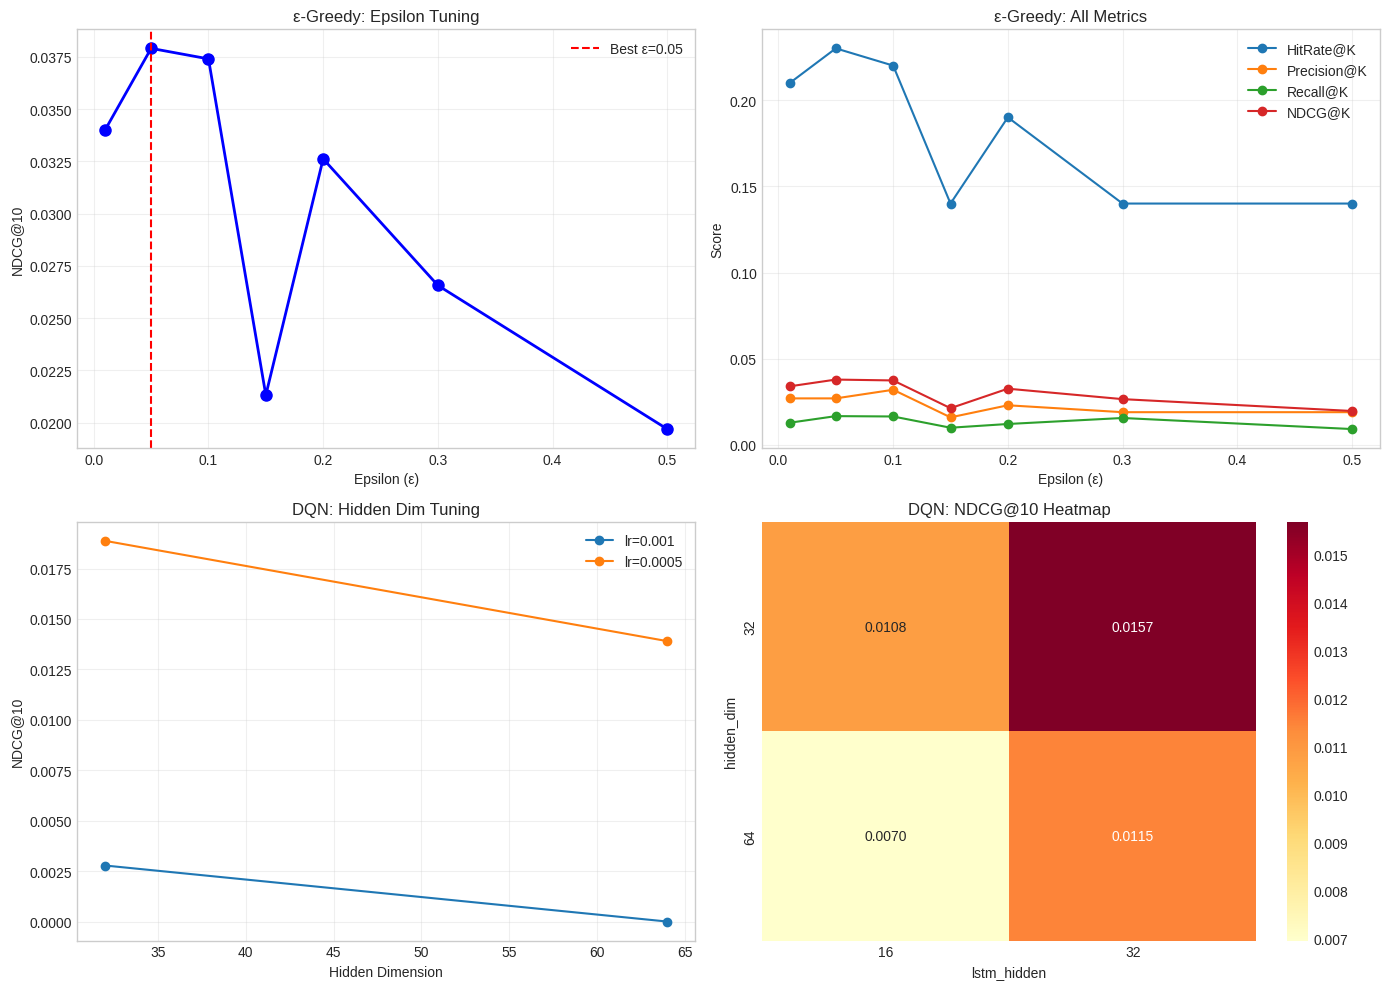

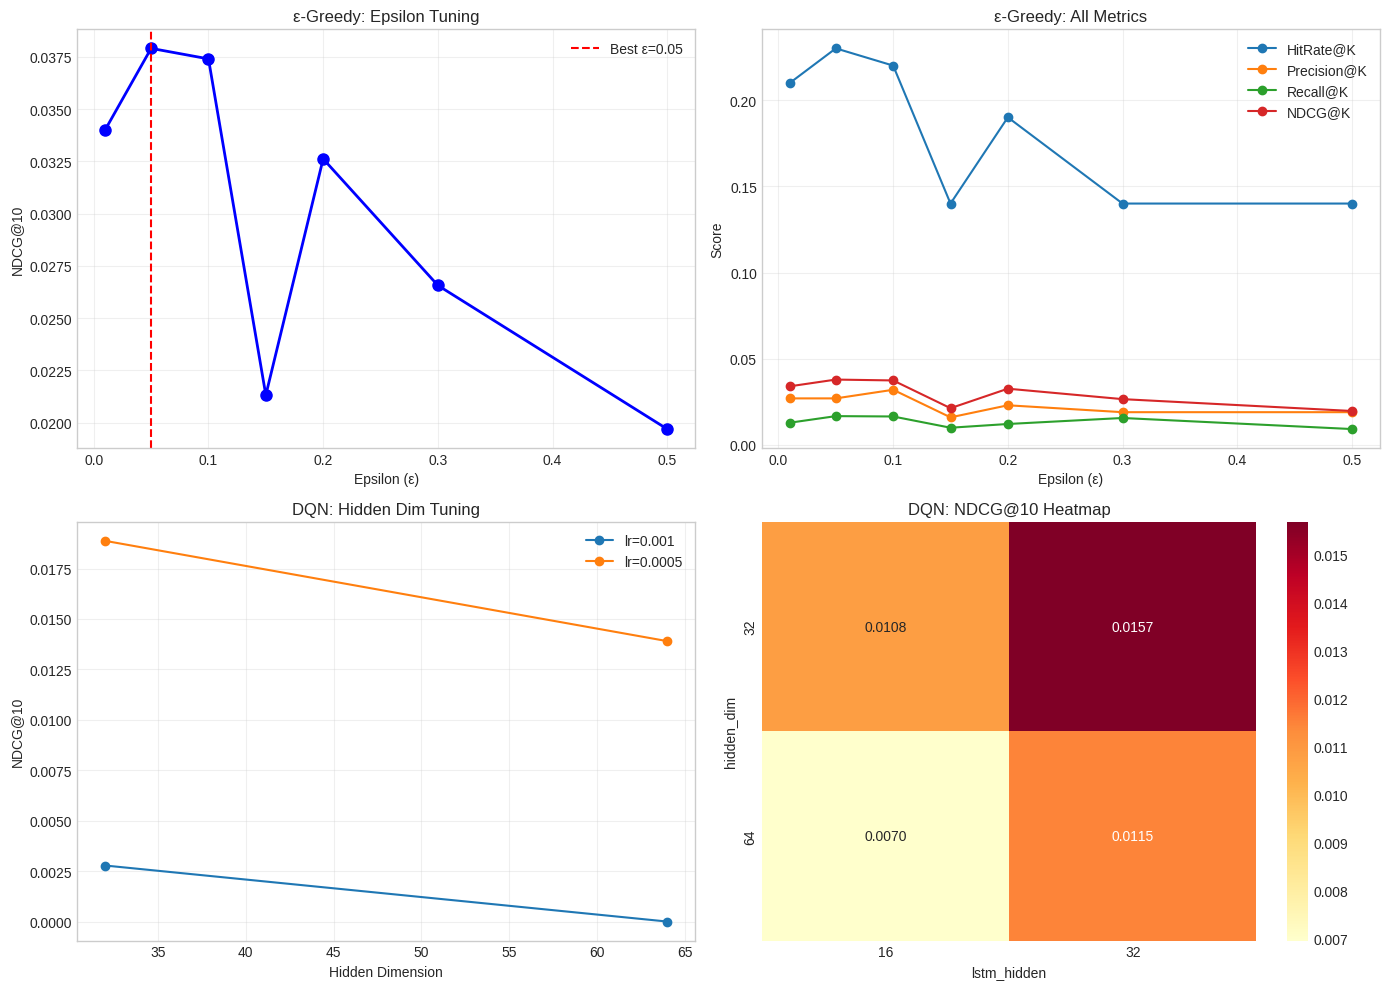

In [16]:
tuner.plot_tuning_results(epsilon_results, dqn_results)

---
# Part 3: 최적 하이퍼파라미터로 최종 모델 학습
---

In [17]:
best_epsilon = epsilon_results.loc[epsilon_results['NDCG@K'].idxmax(), 'epsilon']
best_dqn_config = dqn_results.loc[dqn_results['NDCG@K'].idxmax()]

print("[최적 하이퍼파라미터]")
print(f"  ε-Greedy: epsilon = {best_epsilon}")
print(f"  DQN: hidden={int(best_dqn_config['hidden_dim'])}, "
      f"lstm={int(best_dqn_config['lstm_hidden'])}, "
      f"lr={best_dqn_config['lr']}")

[최적 하이퍼파라미터]
  ε-Greedy: epsilon = 0.05
  DQN: hidden=32, lstm=16, lr=0.0005


In [18]:
print("\n[최종 모델 학습]")
print("="*50)

final_recommenders = {}

final_recommenders['Random'] = RandomRecommender(env)
print("  ✓ Random")

final_recommenders[f'ε-Greedy(ε={best_epsilon})'] = EpsilonGreedyRecommender(env, best_epsilon)
print(f"  ✓ ε-Greedy (ε={best_epsilon})")

final_recommenders['Thompson'] = ThompsonSamplingRecommender(env)
print("  ✓ Thompson Sampling")

print("\n  Sequential DQN 학습 중...")
final_dqn = SequentialDQNRecommender(
    env, embed_dim=20,
    hidden_dim=int(best_dqn_config['hidden_dim']),
    lstm_hidden=int(best_dqn_config['lstm_hidden']),
    lr=best_dqn_config['lr']
)

N_EPISODES = 1000 if torch.cuda.is_available() else 500
final_dqn.train(n_episodes=N_EPISODES, steps_per_episode=10)

final_dqn.save_model('models/dqn_model.pth');
final_recommenders['Sequential-DQN'] = final_dqn

print(f"\n총 {len(final_recommenders)}개 모델 준비 완료")

final_dqn.save_model('models/dqn_model.pth')


[최종 모델 학습]
  ✓ Random
  ✓ ε-Greedy (ε=0.05)
  ✓ Thompson Sampling

  Sequential DQN 학습 중...
Episode 100/500 | Reward: 0.220 | ε: 0.010
Episode 200/500 | Reward: 0.190 | ε: 0.010
Episode 300/500 | Reward: 0.270 | ε: 0.010
Episode 400/500 | Reward: 0.110 | ε: 0.010
Episode 500/500 | Reward: 0.160 | ε: 0.010
✅ 모델 저장 완료: models/dqn_model.pth

총 4개 모델 준비 완료
✅ 모델 저장 완료: models/dqn_model.pth


---
# Part 4: 알고리즘 비교 평가
---

In [19]:
print("\n[최종 평가]")
print("="*50)

final_results = []
K = 10

for name, recommender in final_recommenders.items():
    print(f"  평가: {name}...")
    metrics = evaluator.evaluate_all(recommender, eval_users, k=K)
    metrics['Algorithm'] = name
    final_results.append(metrics)

final_df = pd.DataFrame(final_results)
final_df = final_df[['Algorithm', 'HitRate@K', 'Precision@K', 'Recall@K', 'NDCG@K', 'n_users']]

print("\n[결과]")
display(final_df)


[최종 평가]
  평가: Random...
  평가: ε-Greedy(ε=0.05)...
  평가: Thompson...
  평가: Sequential-DQN...

[결과]


,Algorithm,HitRate@K,Precision@K,Recall@K,NDCG@K,n_users
0,Random,0.12,0.013,0.009144,0.017468,100
1,ε-Greedy(ε=0.05),0.18,0.020,0.012319,0.028604,100
2,Thompson,0.06,0.007,0.004488,0.009027,100
3,Sequential-DQN,0.16,0.019,0.017529,0.021535,100


In [20]:
print("\n[온라인 시뮬레이션]")
print("="*50)

N_SIM_STEPS = 500
cumulative_rewards = {name: [] for name in final_recommenders.keys()}

for name, recommender in final_recommenders.items():
    total_reward = 0
    rewards_history = []

    if isinstance(recommender, ThompsonSamplingRecommender):
        recommender.alpha = defaultdict(lambda: 1.0)
        recommender.beta = defaultdict(lambda: 1.0)

    for step in range(N_SIM_STEPS):
        user_id = random.choice(env.test_users)
        state, candidates = env.reset(user_id)
        if not candidates:
            continue
        action = recommender.select_action(state, candidates)
        _, reward, _, _ = env.step(action)
        total_reward += reward
        if isinstance(recommender, ThompsonSamplingRecommender):
            recommender.update(action, reward)
        rewards_history.append(total_reward)

    cumulative_rewards[name] = rewards_history
    print(f"  {name}: 총 리워드 = {total_reward:.1f}")


[온라인 시뮬레이션]
  Random: 총 리워드 = 3.0
  ε-Greedy(ε=0.05): 총 리워드 = 40.0
  Thompson: 총 리워드 = 1.0
  Sequential-DQN: 총 리워드 = 13.0


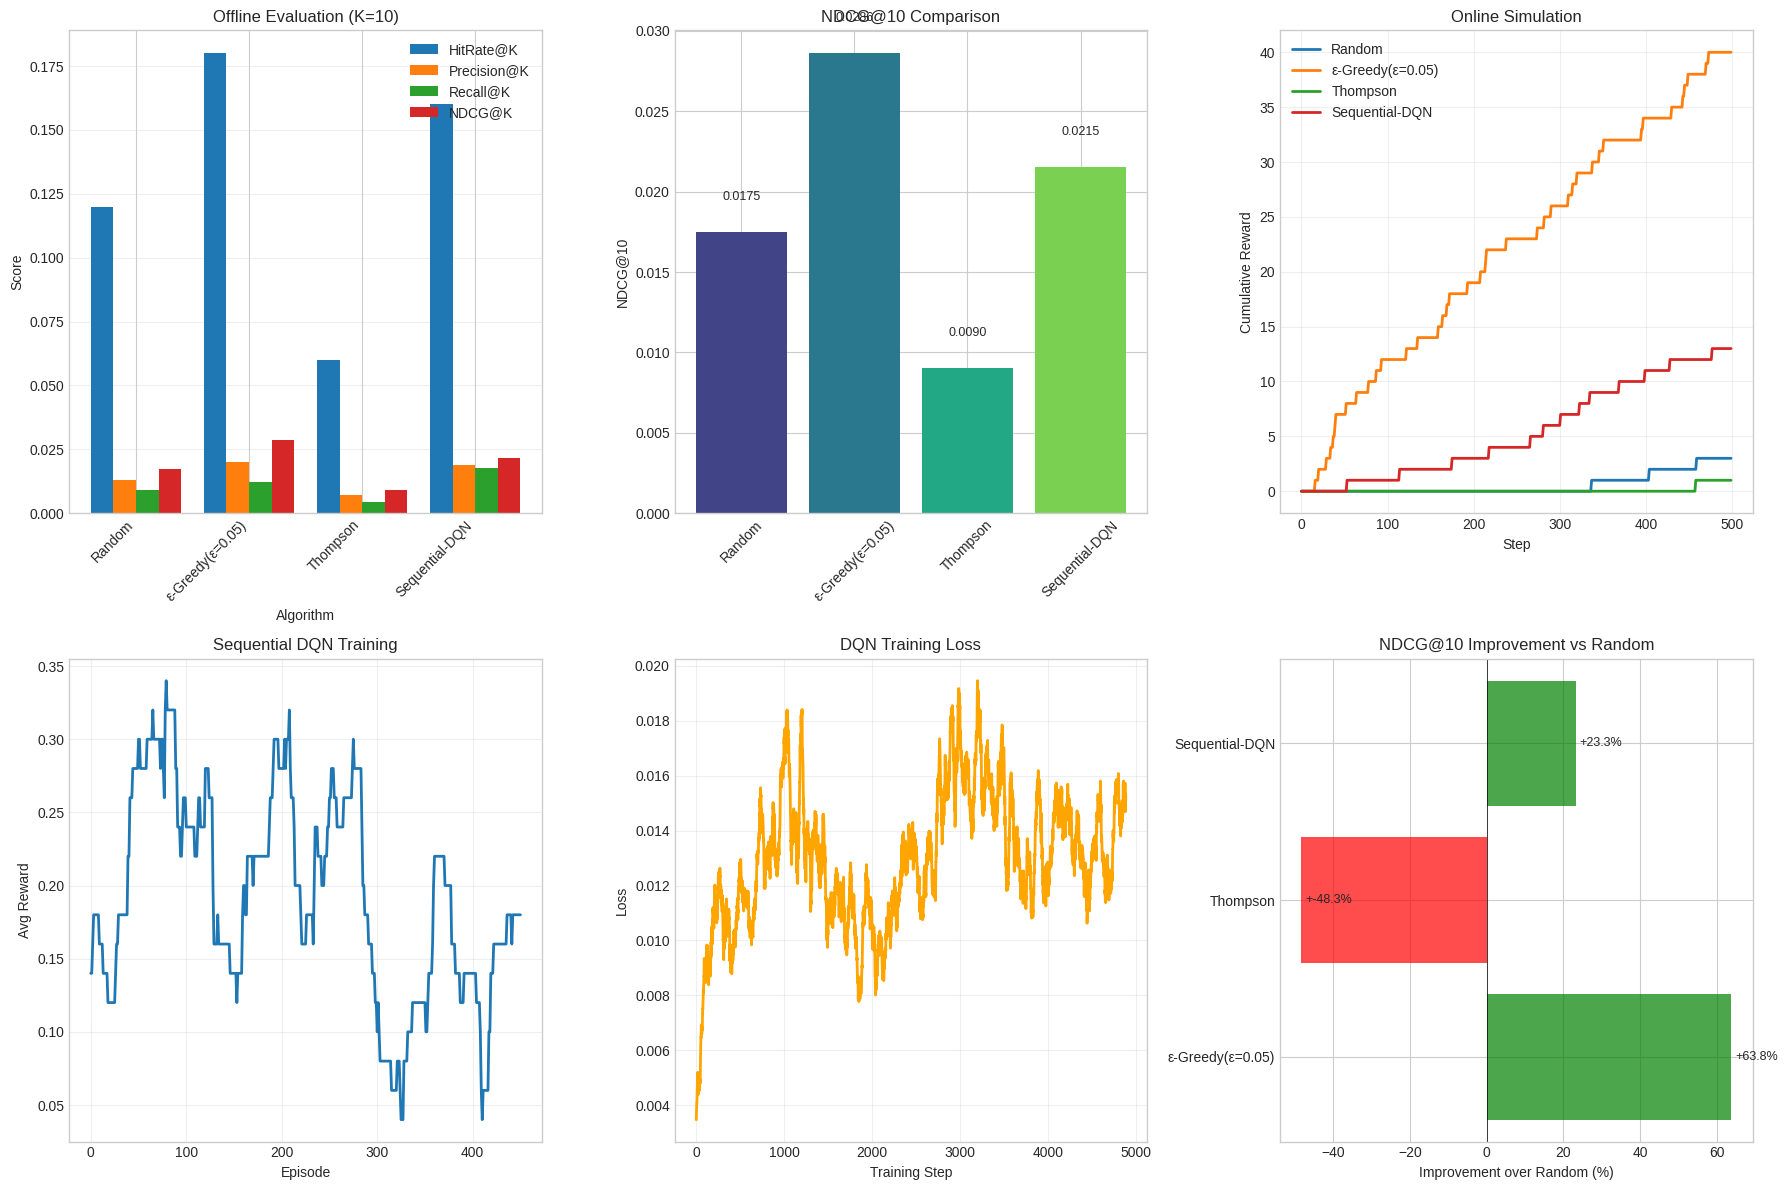

In [21]:
fig = plt.figure(figsize=(18, 12))

ax1 = fig.add_subplot(2, 3, 1)
metrics_cols = ['HitRate@K', 'Precision@K', 'Recall@K', 'NDCG@K']
x = np.arange(len(final_df))
width = 0.2
for i, metric in enumerate(metrics_cols):
    ax1.bar(x + i*width, final_df[metric], width, label=metric)
ax1.set_xlabel('Algorithm')
ax1.set_ylabel('Score')
ax1.set_title('Offline Evaluation (K=10)')
ax1.set_xticks(x + width * 1.5)
ax1.set_xticklabels(final_df['Algorithm'], rotation=45, ha='right')
ax1.legend(loc='upper right')
ax1.grid(axis='y', alpha=0.3)

ax2 = fig.add_subplot(2, 3, 2)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(final_df)))
bars = ax2.bar(final_df['Algorithm'], final_df['NDCG@K'], color=colors)
ax2.set_ylabel('NDCG@10')
ax2.set_title('NDCG@10 Comparison')
ax2.tick_params(axis='x', rotation=45)
for bar, val in zip(bars, final_df['NDCG@K']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, f'{val:.4f}', ha='center', fontsize=9)

ax3 = fig.add_subplot(2, 3, 3)
for name, rewards in cumulative_rewards.items():
    ax3.plot(rewards, label=name, linewidth=2)
ax3.set_xlabel('Step')
ax3.set_ylabel('Cumulative Reward')
ax3.set_title('Online Simulation')
ax3.legend(loc='upper left')
ax3.grid(alpha=0.3)

ax4 = fig.add_subplot(2, 3, 4)
window = 50
if final_dqn.episode_rewards:
    smoothed = np.convolve(final_dqn.episode_rewards, np.ones(window)/window, mode='valid')
    ax4.plot(smoothed, linewidth=2)
ax4.set_xlabel('Episode')
ax4.set_ylabel('Avg Reward')
ax4.set_title('Sequential DQN Training')
ax4.grid(alpha=0.3)

ax5 = fig.add_subplot(2, 3, 5)
if final_dqn.losses:
    smoothed_loss = np.convolve(final_dqn.losses, np.ones(window)/window, mode='valid')
    ax5.plot(smoothed_loss, linewidth=2, color='orange')
ax5.set_xlabel('Training Step')
ax5.set_ylabel('Loss')
ax5.set_title('DQN Training Loss')
ax5.grid(alpha=0.3)

ax6 = fig.add_subplot(2, 3, 6)
random_ndcg = final_df[final_df['Algorithm'] == 'Random']['NDCG@K'].values[0]
improvements, names = [], []
for _, row in final_df.iterrows():
    if row['Algorithm'] != 'Random':
        imp = (row['NDCG@K'] - random_ndcg) / random_ndcg * 100 if random_ndcg > 0 else 0
        improvements.append(imp)
        names.append(row['Algorithm'])
colors = ['green' if x > 0 else 'red' for x in improvements]
bars = ax6.barh(names, improvements, color=colors, alpha=0.7)
ax6.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax6.set_xlabel('Improvement over Random (%)')
ax6.set_title('NDCG@10 Improvement vs Random')
for bar, val in zip(bars, improvements):
    ax6.text(val + 1, bar.get_y() + bar.get_height()/2, f'+{val:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('final_results.png', dpi=150, bbox_inches='tight')
plt.show()

---
# Part 5: 최적 알고리즘 선택
---

In [22]:
best_idx = final_df['NDCG@K'].idxmax()
best_algo_name = final_df.loc[best_idx, 'Algorithm']
best_ndcg = final_df.loc[best_idx, 'NDCG@K']

best_recommender = final_recommenders[best_algo_name]

print("="*50)
print(f"🏆 최적 알고리즘: {best_algo_name}")
print(f"   NDCG@10: {best_ndcg:.4f}")
print("="*50)

🏆 최적 알고리즘: ε-Greedy(ε=0.05)
   NDCG@10: 0.0286


---
# Part 6: 최종 추천 시스템 (TMDB API)
---

In [23]:
class TMDBMovieInfo:
    def __init__(self, api_key):
        self.api_key = api_key
        self.base_url = "https://api.themoviedb.org/3"
        self.image_base_url = "https://image.tmdb.org/t/p/w500"
        self.cache = {}

    def search_movie(self, title, year=None):
        cache_key = f"{title}_{year}"
        if cache_key in self.cache:
            return self.cache[cache_key]

        url = f"{self.base_url}/search/movie"
        params = {'api_key': self.api_key, 'query': title, 'language': 'ko-KR'}
        if year:
            params['year'] = year

        try:
            response = requests.get(url, params=params, timeout=10)
            data = response.json()
            if data.get('results') and len(data['results']) > 0:
                movie = data['results'][0]
                result = self._parse_movie_data(movie)
                self.cache[cache_key] = result
                return result
            return None
        except Exception as e:
            print(f"[TMDB Error] {e}")
            return None

    def _parse_movie_data(self, movie):
        poster_path = movie.get('poster_path')
        poster_url = f"{self.image_base_url}{poster_path}" if poster_path else None
        return {
            'tmdb_id': movie.get('id'),
            'title': movie.get('title'),
            'original_title': movie.get('original_title'),
            'overview': movie.get('overview', '줄거리 정보가 없습니다.'),
            'release_date': movie.get('release_date', ''),
            'vote_average': movie.get('vote_average', 0),
            'vote_count': movie.get('vote_count', 0),
            'poster_url': poster_url
        }

    def get_movie_details(self, tmdb_id):
        url = f"{self.base_url}/movie/{tmdb_id}"
        params = {'api_key': self.api_key, 'language': 'ko-KR'}
        try:
            response = requests.get(url, params=params, timeout=10)
            data = response.json()
            genres = [g['name'] for g in data.get('genres', [])]
            return {'genres': genres, 'runtime': data.get('runtime', 0), 'tagline': data.get('tagline', '')}
        except:
            return {'genres': [], 'runtime': 0, 'tagline': ''}

In [24]:
class FinalRecommendationSystem:
    def __init__(self, recommender, loader, tmdb_api_key):
        self.recommender = recommender
        self.loader = loader
        self.tmdb = TMDBMovieInfo(tmdb_api_key) if tmdb_api_key != "YOUR_API_KEY_HERE" else None

    def _parse_movielens_title(self, title):
        try:
            if '(' in title and ')' in title:
                year_str = title[title.rfind('(')+1:title.rfind(')')]
                clean_title = title[:title.rfind('(')].strip()
                return clean_title, int(year_str)
        except:
            pass
        return title, None

    def recommend_for_user(self, user_id, n_recommendations=5):
        recs = self.recommender.get_recommendations(user_id, k=n_recommendations)
        if not recs:
            return []

        recommendations = []
        for i, rec in enumerate(recs):
            movie_id = rec['movieId']
            score = rec['score']
            ml_info = self.loader.get_movie_info(movie_id)
            if ml_info is None:
                continue

            movie_data = {
                'rank': i + 1,
                'movieId': movie_id,
                'ml_title': ml_info['title'],
                'ml_genres': ml_info['genres'],
                'score': score
            }

            if self.tmdb:
                clean_title, year = self._parse_movielens_title(ml_info['title'])
                tmdb_info = self.tmdb.search_movie(clean_title, year)
                if tmdb_info:
                    movie_data['tmdb'] = tmdb_info
                    details = self.tmdb.get_movie_details(tmdb_info['tmdb_id'])
                    movie_data['tmdb_details'] = details

            recommendations.append(movie_data)
        return recommendations

    def display_recommendations(self, user_id, n_recommendations=5):
        recommendations = self.recommend_for_user(user_id, n_recommendations)
        if not recommendations:
            print(f"유저 {user_id}에게 추천할 영화가 없습니다.")
            return

        html = f"""
        <div style="font-family: 'Segoe UI', Arial, sans-serif; max-width: 900px; margin: 0 auto;">
            <div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                        color: white; padding: 20px; border-radius: 15px 15px 0 0; text-align: center;">
                <h1 style="margin: 0;">🎬 유저 #{user_id}님을 위한 추천 영화</h1>
                <p style="margin: 10px 0 0 0; opacity: 0.9;">추천 알고리즘: {self.recommender.name}</p>
            </div>
        """

        for movie in recommendations:
            rank = movie['rank']
            title = movie['ml_title']
            genres = movie['ml_genres']

            poster_html = ""
            overview = "영화 정보를 불러올 수 없습니다."
            tmdb_rating = ""
            tmdb_genres = genres.replace('|', ', ')

            if 'tmdb' in movie:
                tmdb = movie['tmdb']
                if tmdb.get('poster_url'):
                    poster_html = f'<img src="{tmdb["poster_url"]}" style="width: 150px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0,0,0,0.3);" alt="{title}">'
                overview = tmdb.get('overview', '줄거리 정보가 없습니다.')
                if len(overview) > 300:
                    overview = overview[:300] + '...'
                if tmdb.get('vote_average'):
                    rating = tmdb['vote_average']
                    stars = '★' * int(rating/2) + '☆' * (5 - int(rating/2))
                    tmdb_rating = f"<span style='color: #f39c12;'>{stars}</span> ({rating}/10)"
                if 'tmdb_details' in movie and movie['tmdb_details'].get('genres'):
                    tmdb_genres = ', '.join(movie['tmdb_details']['genres'])

            medal_colors = {1: '#FFD700', 2: '#C0C0C0', 3: '#CD7F32'}
            medal_color = medal_colors.get(rank, '#667eea')

            html += f"""
            <div style="display: flex; background: white; margin: 15px; padding: 20px;
                        border-radius: 15px; box-shadow: 0 2px 10px rgba(0,0,0,0.1);">
                <div style="text-align: center; margin-right: 20px;">
                    <div style="background: {medal_color}; color: white; width: 40px; height: 40px;
                                border-radius: 50%; display: flex; align-items: center; justify-content: center;
                                font-weight: bold; font-size: 18px; margin: 0 auto 10px auto;">{rank}</div>
                    {poster_html if poster_html else '<div style="width:150px;height:225px;background:#eee;border-radius:10px;display:flex;align-items:center;justify-content:center;color:#999;">No Poster</div>'}
                </div>
                <div style="flex: 1;">
                    <h2 style="margin: 0 0 10px 0; color: #333;">{title}</h2>
                    <div style="margin-bottom: 10px;">
                        <span style="background: #667eea; color: white; padding: 3px 10px;
                                     border-radius: 15px; font-size: 12px;">{tmdb_genres}</span>
                    </div>
                    <p style="color: #666; line-height: 1.6; margin: 10px 0;">{overview}</p>
                    <div style="display: flex; gap: 20px; margin-top: 15px; color: #888; font-size: 14px;">
                        <span>🎯 추천 점수: <strong>{movie['score']:.2f}</strong></span>
                        {f'<span>⭐ TMDB 평점: {tmdb_rating}</span>' if tmdb_rating else ''}
                    </div>
                </div>
            </div>
            """

        html += "</div>"
        display(HTML(html))
        return recommendations

In [25]:
final_system = FinalRecommendationSystem(
    recommender=best_recommender,
    loader=loader,
    tmdb_api_key=TMDB_API_KEY
)

if TMDB_API_KEY == "YOUR_API_KEY_HERE":
    print("⚠️ TMDB API 키를 입력하면 포스터와 줄거리가 표시됩니다!")
else:
    print("✅ TMDB API 연동 완료!")

✅ TMDB API 연동 완료!


## 🎬 영화 추천 실행!

In [26]:
sample_user = random.choice(eval_users)
print(f"유저 #{sample_user}에게 추천 중...\n")
final_system.display_recommendations(sample_user, n_recommendations=5)

유저 #589에게 추천 중...



[{'rank': 1,
  'movieId': 21,
  'ml_title': 'Get Shorty (1995)',
  'ml_genres': 'Comedy|Crime|Thriller',
  'score': np.float64(0.2244249011838211)},
 {'rank': 2,
  'movieId': 377,
  'ml_title': 'Speed (1994)',
  'ml_genres': 'Action|Romance|Thriller',
  'score': np.float64(0.17438180785559926)},
 {'rank': 3,
  'movieId': 434,
  'ml_title': 'Cliffhanger (1993)',
  'ml_genres': 'Action|Adventure|Thriller',
  'score': np.float64(0.10842627093378546)},
 {'rank': 4,
  'movieId': 1090,
  'ml_title': 'Platoon (1986)',
  'ml_genres': 'Drama|War',
  'score': np.float64(0.0731959798444737)},
 {'rank': 5,
  'movieId': 7153,
  'ml_title': 'Lord of the Rings: The Return of the King, The (2003)',
  'ml_genres': 'Action|Adventure|Drama|Fantasy',
  'score': np.float64(0.06274382785950827)}]

In [27]:
another_user = random.choice(eval_users)
print(f"유저 #{another_user}에게 추천 중...\n")
final_system.display_recommendations(another_user, n_recommendations=5)

유저 #413에게 추천 중...



[{'rank': 1,
  'movieId': 608,
  'ml_title': 'Fargo (1996)',
  'ml_genres': 'Comedy|Crime|Drama|Thriller',
  'score': np.float64(0.28050329270520985)},
 {'rank': 2,
  'movieId': 7361,
  'ml_title': 'Eternal Sunshine of the Spotless Mind (2004)',
  'ml_genres': 'Drama|Romance|Sci-Fi',
  'score': np.float64(0.21338392550191462)},
 {'rank': 3,
  'movieId': 1206,
  'ml_title': 'Clockwork Orange, A (1971)',
  'ml_genres': 'Crime|Drama|Sci-Fi|Thriller',
  'score': np.float64(0.1603214406063962)},
 {'rank': 4,
  'movieId': 64614,
  'ml_title': 'Gran Torino (2008)',
  'ml_genres': 'Crime|Drama',
  'score': np.float64(0.12417173822522826)},
 {'rank': 5,
  'movieId': 1252,
  'ml_title': 'Chinatown (1974)',
  'ml_genres': 'Crime|Film-Noir|Mystery|Thriller',
  'score': np.float64(0.0881533335444799)}]

In [28]:
sample_users = random.sample(eval_users, 3)
for user_id in sample_users:
    print("\n" + "="*80)
    final_system.display_recommendations(user_id, n_recommendations=3)

---
# 📊 최종 요약
---

In [29]:
print("="*70)
print("📊 프로젝트 결과 요약")
print("="*70)

print("\n[1] 하이퍼파라미터 튜닝")
print("-"*50)
print(f"  최적 Epsilon: {best_epsilon}")
print(f"  최적 DQN: hidden={int(best_dqn_config['hidden_dim'])}, "
      f"lstm={int(best_dqn_config['lstm_hidden'])}, lr={best_dqn_config['lr']}")

print("\n[2] 알고리즘 비교 결과")
print("-"*50)
print(final_df.to_string(index=False))

print(f"\n[3] 최적 알고리즘")
print("-"*50)
print(f"  🏆 {best_algo_name}")
print(f"  NDCG@10: {best_ndcg:.4f}")

random_ndcg = final_df[final_df['Algorithm'] == 'Random']['NDCG@K'].values[0]
improvement = (best_ndcg - random_ndcg) / random_ndcg * 100 if random_ndcg > 0 else 0
print(f"  Random 대비: +{improvement:.1f}%")

print(f"\n[4] 최종 시스템")
print("-"*50)
print(f"  추천 알고리즘: {best_algo_name}")
print(f"  영화 정보: {'TMDB API (포스터 + 줄거리)' if TMDB_API_KEY != 'YOUR_API_KEY_HERE' else 'MovieLens 기본'}")

print("\n" + "="*70)
print("🎉 프로젝트 완료!")
print("="*70)

📊 프로젝트 결과 요약

[1] 하이퍼파라미터 튜닝
--------------------------------------------------
  최적 Epsilon: 0.05
  최적 DQN: hidden=32, lstm=16, lr=0.0005

[2] 알고리즘 비교 결과
--------------------------------------------------
       Algorithm  HitRate@K  Precision@K  Recall@K   NDCG@K  n_users
          Random       0.12        0.013  0.009144 0.017468      100
ε-Greedy(ε=0.05)       0.18        0.020  0.012319 0.028604      100
        Thompson       0.06        0.007  0.004488 0.009027      100
  Sequential-DQN       0.16        0.019  0.017529 0.021535      100

[3] 최적 알고리즘
--------------------------------------------------
  🏆 ε-Greedy(ε=0.05)
  NDCG@10: 0.0286
  Random 대비: +63.8%

[4] 최종 시스템
--------------------------------------------------
  추천 알고리즘: ε-Greedy(ε=0.05)
  영화 정보: TMDB API (포스터 + 줄거리)

🎉 프로젝트 완료!


In [30]:
final_df.to_csv('final_results.csv', index=False)
epsilon_results.to_csv('epsilon_tuning.csv', index=False)
dqn_results.to_csv('dqn_tuning.csv', index=False)
print("결과 저장 완료!")

결과 저장 완료!
